From DataCamp:

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. 

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

In [1]:
import pandas as pd

cookiecats = pd.read_csv('cookie_cats.csv')

In [2]:
cookiecats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Overall 1-day retention

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall.

In [3]:
# The % of users that came back the day after they installed
print(round(cookiecats['retention_1'].sum()/cookiecats['retention_1'].count(),3)*100,'%')

44.5 %


In [4]:
# Calculating 1-day retention for each AB-group
retention1group = cookiecats.groupby('version')['retention_1']
retention1group.sum()/retention1group.count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

<AxesSubplot:ylabel='Density'>

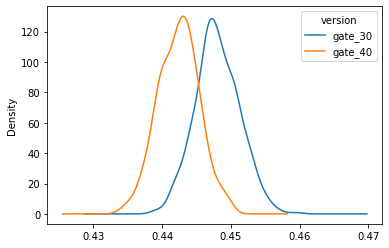

In [5]:
boot_1d = []
#create 500 iterations
for i in range(500):
    boot_mean = cookiecats.sample(frac=1,replace= True).groupby('version')['retention_1'].sum()/cookiecats.sample(frac=1,replace= True).groupby('version')['retention_1'].count()
    boot_1d.append(boot_mean)

#create dataframe    
boot_1d = pd.DataFrame(boot_1d)

#plot the kde
boot_1d.plot.kde()

In [8]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff%'] = ((boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40'])*100
boot_1d

version,gate_30,gate_40,diff%
retention_1,0.451099,0.441299,2.220775
retention_1,0.447033,0.439874,1.627480
retention_1,0.446866,0.442841,0.908971
retention_1,0.448047,0.441939,1.382102
retention_1,0.449395,0.445327,0.913482
...,...,...,...
retention_1,0.446453,0.443300,0.711351
retention_1,0.446221,0.443203,0.680947
retention_1,0.445140,0.445256,-0.026123
retention_1,0.454749,0.441823,2.925492


In [7]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff%']>0).mean()
print(prob*100,'%')

86.0 %


# 7 Day Retention

We saw there was a high probability that 1-day retention is better when the gate is at level 30. However, it is possible that many players do not reach the level 30 and level 40 gates within 1 day. Therefore, many players wouldn't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

Let's start by calculating 7-day retention for the two AB-groups.

In [13]:
retention7group = cookiecats.groupby('version')['retention_7'].mean()
retention7group

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

It seems there's a noticeable difference in 7 day retention between gate 30 and gate 40 groups. Similar to what we did when looking at 1 day retention, let's bootstrap again to have a greater confidence in this difference.

<AxesSubplot:ylabel='Density'>

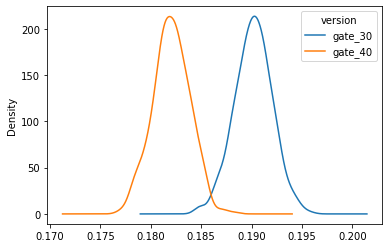

In [27]:
boot_7d = []
for i in range(500):
    boot_mean = cookiecats.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

#create dataframe    
boot_7d = pd.DataFrame(boot_7d)

#plot the kde
boot_7d.plot.kde()

In [28]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30']/boot_7d['gate_40']) - 1

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()
print(prob*100,'%')

99.8 %


# Conclusion 

After bootstrapping, 7-day retention is clearly increased when the gate is at level 30 as opposed to level 40; if overall player retention is a priority, we should not move the gate from level 30 to level 40. 

The moderators mention other potential metrics, such as the number of game rounds played or how much in-game purchases are made by the two AB-groups. I do agree with these metrics, but I also want to add the metric of time to first purchase. If, for instance, average time to first purchase is 14 days, we should start looking at 14 day retention alongside 7 day retention.
